In [839]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import contractions
import random
import fasttext
from autocorrect import spell
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', 200)

In [2]:
with open('apple_scrape.csv') as f:
    df = pd.read_csv(f)
f.close()

In [3]:
df.head()

,Unnamed: 0,rating,rating_title,rating_description,rating_pros,rating_cons
0,0,5.0,The Best Job Ever,"Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy...",Work environment,Parking
1,1,2.0,No Value for Tenured Employees,"If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp...",NaN,NaN
2,2,5.0,good,It is good company better company it's with good job . your company my self product with my seller good condition your nice company imploy good job you are best,good,very nice
3,3,5.0,Actively looking for job change in Big data technologies,Actively looking for job change in Big data technologies. I am having total 5.8 years of experience in IT industry. I am ready to work on any technology.,NaN,NaN
4,4,5.0,Great place to work at`,"Everything is good except it is extremely hard to advance further up. Flexible hour and decent pay. If you start out as a part time, be prepared to stay as a part time for a long while before you ...",NaN,NaN


In [4]:
# Just over 3800 reviews
df.shape

(4851, 6)

In [5]:
df['rating'].value_counts()

5.0    2465
4.0    1304
3.0     665
2.0     227
1.0     190
Name: rating, dtype: int64

In [6]:
df = df[['rating', 'rating_description']]
df.head()

,rating,rating_description
0,5.0,"Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy..."
1,2.0,"If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp..."
2,5.0,It is good company better company it's with good job . your company my self product with my seller good condition your nice company imploy good job you are best
3,5.0,Actively looking for job change in Big data technologies. I am having total 5.8 years of experience in IT industry. I am ready to work on any technology.
4,5.0,"Everything is good except it is extremely hard to advance further up. Flexible hour and decent pay. If you start out as a part time, be prepared to stay as a part time for a long while before you ..."


### Removing Contractions

In [7]:
# Removing contractions
df['no_contract'] = df['rating_description'].apply(lambda x: [contractions.fix(word) for word in x.split()])


In [8]:
# Converting list back to a string
df['rating_desc_str'] = [' '.join(map(str, l)) for l in df['no_contract']]

### Removing Non-English Reviews

In [9]:
# loading a pretained model and predicting the language of the review
pretrained_model = "lid.176.bin" 
model = fasttext.load_model(pretrained_model)

langs = []
for sent in df['rating_desc_str']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])

df['langs'] = langs

df.head()

,rating,rating_description,no_contract,rating_desc_str,langs
0,5.0,"Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy...","[Working, at, Apple, was, a, great, experience., Work, never, felt, like, work, because, I, loved, what, I, did, and, I, loved, interacting, with, the, public., The, store, was, always, electric,,...","Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy....",en
1,2.0,"If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp...","[If, you, are, looking, for, a, company, that, will, value, you, as, time, goes, by,, look, somewhere, else., After, 18+, hard, years,, management, raised, the, expectations, of, my, job, making, ...","If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp...",en
2,5.0,It is good company better company it's with good job . your company my self product with my seller good condition your nice company imploy good job you are best,"[It, is, good, company, better, company, it is, with, good, job, ., your, company, my, self, product, with, my, seller, good, condition, your, nice, company, imploy, good, job, you, are, best]",It is good company better company it is with good job . your company my self product with my seller good condition your nice company imploy good job you are best,en
3,5.0,Actively looking for job change in Big data technologies. I am having total 5.8 years of experience in IT industry. I am ready to work on any technology.,"[Actively, looking, for, job, change, in, Big, data, technologies., I, am, having, total, 5.8, years, of, experience, in, IT, industry., I, am, ready, to, work, on, any, technology.]",Actively looking for job change in Big data technologies. I am having total 5.8 years of experience in IT industry. I am ready to work on any technology.,en
4,5.0,"Everything is good except it is extremely hard to advance further up. Flexible hour and decent pay. If you start out as a part time, be prepared to stay as a part time for a long while before you ...","[Everything, is, good, except, it, is, extremely, hard, to, advance, further, up., Flexible, hour, and, decent, pay., If, you, start, out, as, a, part, time,, be, prepared, to, stay, as, a, part, ...","Everything is good except it is extremely hard to advance further up. Flexible hour and decent pay. If you start out as a part time, be prepared to stay as a part time for a long while before you ...",en


In [10]:
# removing all non-english reviews
df = df[df['langs'] == 'en']

### Tokenizing

In [11]:
df['tokenized'] = df['rating_desc_str'].apply(word_tokenize)

### Removing Punctuations and Special Characters

In [12]:
df['no_punc'] = df['tokenized'].apply(lambda x: [word for word in x if word.isalnum()])

### Converting All Tokens to Lowercase

In [13]:
df['lower'] = df['no_punc'].apply(lambda x: [word.lower() for word in x])

### Spell Check

In [14]:
df['spell'] = df['lower'].apply(lambda x: [spell(word) for word in x])

### Removing any Numerical Characters

In [15]:
df['no_num'] = df['spell'].apply(lambda x: [word for word in x if word.isalpha()])

### Lemmatization

In [16]:
# Using NLTK to tag parts of speech for each token
df['pos_tags'] = df['no_num'].apply(nltk.tag.pos_tag)

In [17]:
# Function to convert NLTK's POS to wordnet's POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [19]:
# Finally lammatizing the tokens
wnl = WordNetLemmatizer()
df['lemma'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for (word, tag) in x])

### Removing Stopwords

In [22]:
# removing stop words
stop_words = set(stopwords.words('english'))
df['stop_removed'] = df['lemma'].apply(lambda x: [word for word in x if word not in stop_words])


### Removing Words Less than 3 Characters Long

In [24]:
# removing words less than or equal to 2 characters
def short_words(words):
    return [word for word in words if len(word) > 2]

df['length'] = df['stop_removed'].apply(short_words)

In [25]:
df.head()

,rating,rating_description,no_contract,rating_desc_str,langs,tokenized,no_punc,lower,spell,no_num,pos_tags,wordnet_pos,lemma,stop_removed,length
0,5.0,"Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy...","[Working, at, Apple, was, a, great, experience., Work, never, felt, like, work, because, I, loved, what, I, did, and, I, loved, interacting, with, the, public., The, store, was, always, electric,,...","Working at Apple was a great experience. Work never felt like work because I loved what I did and I loved interacting with the public. The store was always electric, although others may say crazy....",en,"[Working, at, Apple, was, a, great, experience, ., Work, never, felt, like, work, because, I, loved, what, I, did, and, I, loved, interacting, with, the, public, ., The, store, was, always, electr...","[Working, at, Apple, was, a, great, experience, Work, never, felt, like, work, because, I, loved, what, I, did, and, I, loved, interacting, with, the, public, The, store, was, always, electric, al...","[working, at, apple, was, a, great, experience, work, never, felt, like, work, because, i, loved, what, i, did, and, i, loved, interacting, with, the, public, the, store, was, always, electric, al...","[working, at, apple, was, a, great, experience, work, never, felt, like, work, because, i, loved, what, i, did, and, i, loved, interacting, with, the, public, the, store, was, always, electric, al...","[working, at, apple, was, a, great, experience, work, never, felt, like, work, because, i, loved, what, i, did, and, i, loved, interacting, with, the, public, the, store, was, always, electric, al...","[(working, VBG), (at, IN), (apple, NN), (was, VBD), (a, DT), (great, JJ), (experience, NN), (work, NN), (never, RB), (felt, VBD), (like, JJ), (work, NN), (because, IN), (i, NN), (loved, VBD), (wha...","[(working, v), (at, n), (apple, n), (was, v), (a, n), (great, a), (experience, n), (work, n), (never, r), (felt, v), (like, a), (work, n), (because, n), (i, n), (loved, v), (what, n), (i, n), (did...","[work, at, apple, be, a, great, experience, work, never, felt, like, work, because, i, love, what, i, do, and, i, love, interact, with, the, public, the, store, be, always, electric, although, oth...","[work, apple, great, experience, work, never, felt, like, work, love, love, interact, public, store, always, electric, although, others, may, say, crazy, would, say, electric, experience, exhilara...","[work, apple, great, experience, work, never, felt, like, work, love, love, interact, public, store, always, electric, although, others, may, say, crazy, would, say, electric, experience, exhilara..."
1,2.0,"If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp...","[If, you, are, looking, for, a, company, that, will, value, you, as, time, goes, by,, look, somewhere, else., After, 18+, hard, years,, management, raised, the, expectations, of, my, job, making, ...","If you are looking for a company that will value you as time goes by, look somewhere else. After 18+ hard years, management raised the expectations of my job making it basically impossible to comp...",en,"[If, you, are, looking, for, a, company, that, will, value, you, as, time, goes, by, ,, look, somewhere, else, ., After, 18+, hard, years, ,, management, raised, the, expectations, of, my, job, ma...","[If, you, are, looking, for, a, company, that, will, value, you, as, time, goes, by, look, somewhere, else, After, hard, years, management, raised, the, expectations, of, my, job, making, it, basi...","[if, you, are, looking, for, a, company, that, will, value, you, as, time, goes, by, look, somewhere, else, after, hard, years, management, raised, the, expectations, of, my, job, making, it, basi...",

### Determining Target Labels (ie + or - sentiment)

In [320]:
# reviews 5 and 4 are positve
# reviews 1,2 are negative
# Removing neutral ratings
# sort the positive reviews first and the negative reviews second

def sent(df):
    if df['rating'] <= 2:
        val = 1.0
    elif df['rating'] >= 4:
        val = 0.0
    else:
        val = -1.0
    return val

In [321]:
df.rating.value_counts()/len(df)

5.0    0.504882
4.0    0.269690
3.0    0.137774
2.0    0.047733
1.0    0.039922
Name: rating, dtype: float64

In [322]:
df['sentiment'] = df.apply(sent, axis=1) 

In [330]:
df = df.loc[(df['sentiment']==1) | (df['sentiment']==0)]

In [458]:
df.sentiment.value_counts()

0.0    3570
1.0     404
Name: sentiment, dtype: int64

In [332]:
df = df[['rating', 'length', 'sentiment']]
df.head()

,rating,length,sentiment
3,1.0,"[work, apple, contractor, different, time, different, contractor, company, different, city, month, able, make, objective, observation, specific, location, contractor, company, really, happen, like...",1.0
5,1.0,"[good, company, work, corporate, office, career, advancement, manage, staff, may, manager, recent, job, current, role]",1.0
7,2.0,"[definitely, much, cult, think, manager, offer, little, help, especially, employee, school, must, suck, management, order, get, promotion, within]",1.0
10,1.0,"[good, people, work, organize, shop, disappointed, customer, clot, blame, put, employee, instead, management]",1.0
12,1.0,"[first, day, train, talk, sale, goal, suppose, push, sale, treat, employee, fairly, false, sale, big, big, part, job, want, push, every, product, service, however, get, commission, manager, favori...",1.0


In [333]:
df.sort_values(by='sentiment', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

In [334]:
df.head()

,rating,length,sentiment
0,1.0,"[work, apple, contractor, different, time, different, contractor, company, different, city, month, able, make, objective, observation, specific, location, contractor, company, really, happen, like...",1.0
1,2.0,"[work, several, big, company, silicon, valley, far, political, environment, work, change, decide, high, level, push, organization, often, little, opportunity, team, provide, feedback, work, projec...",1.0
2,1.0,"[first, job, become, drain, balance, literally, neglect, family, apple, syr, old, daughter, work, holiday, even, open, xmas, SMP]",1.0
3,2.0,"[good, environment, since, many, work, many, stress, relate, job, environment, like, environment]",1.0
4,2.0,"[work, apple, benefit, highly, enthusiastic, brand, find, engage, however, progression, dangle, front, constantly, goalpost, constantly, move, answer, management, range, simply, hop, find, soon, p...",1.0


In [336]:
df_pos = df[df['sentiment'] == 0.0]
df_neg = df[df['sentiment'] == 1.0]

In [459]:
# create an array of 3570 1s and 1039 0s as our targets
targets = np.append(np.ones(len(df_neg)), np.zeros(len(df_pos)))
targets


array([1., 1., 1., ..., 0., 0., 0.])

In [338]:
# frequency of each word depending on its target
# Each word in pos reviews was labled as pos (ie 0) and counted how many times it shows up in the pos reviews
# Each word in neg reviews was labeled as neg (ie 1) and counted how many times it shows up in the neg reviews
frequencies = {}
for y, words in zip(targets, df['length']):
    for word in words:
        pair = (word, y)
        if pair in frequencies:
            frequencies[pair] += 1
        else:
            frequencies[pair] = 1
            
print(frequencies)

{('work', 1.0): 425, ('apple', 1.0): 279, ('contractor', 1.0): 35, ('different', 1.0): 26, ('time', 1.0): 119, ('company', 1.0): 167, ('city', 1.0): 2, ('month', 1.0): 24, ('able', 1.0): 12, ('make', 1.0): 94, ('objective', 1.0): 1, ('observation', 1.0): 1, ('specific', 1.0): 5, ('location', 1.0): 10, ('really', 1.0): 39, ('happen', 1.0): 13, ('like', 1.0): 114, ('millennial', 1.0): 1, ('product', 1.0): 43, ('prefer', 1.0): 1, ('use', 1.0): 41, ('personally', 1.0): 4, ('excite', 1.0): 3, ('see', 1.0): 25, ('thing', 1.0): 35, ('inside', 1.0): 8, ('expect', 1.0): 24, ('nice', 1.0): 16, ('healthy', 1.0): 3, ('culture', 1.0): 48, ('manager', 1.0): 117, ('think', 1.0): 37, ('outside', 1.0): 9, ('box', 1.0): 4, ('however', 1.0): 27, ('reality', 1.0): 4, ('could', 1.0): 23, ('far', 1.0): 11, ('seem', 1.0): 22, ('stilet', 1.0): 1, ('fusty', 1.0): 1, ('patronizing', 1.0): 1, ('employee', 1.0): 133, ('feel', 1.0): 32, ('small', 1.0): 7, ('worthless', 1.0): 1, ('disposable', 1.0): 3, ('mean', 1.0

In [339]:
 words = [word[0] for word in frequencies]

# our list which will contain the word along with the pos and neg counts
data = []

for word in words:
    pos_count = 0
    neg_count = 0
    
    # if the tuple key ('apple, 1') in frequencies
    if (word, 1) in frequencies:
        # remember frequencies is a dictionary and we index the value using the key inside of brackets
        # example: frequencies['work', 1] will return 425
        # neg_count become 425 in this iteration 
        neg_count = frequencies[(word,1)]
    # if the tuple key ('apple, 0') in frequencies    
    if (word, 0) in frequencies:
        pos_count = frequencies[(word, 0)]

    data.append([word, neg_count, pos_count])

data

[['work', 425, 4674],
 ['apple', 279, 2696],
 ['contractor', 35, 44],
 ['different', 26, 219],
 ['time', 119, 997],
 ['company', 167, 1391],
 ['city', 2, 15],
 ['month', 24, 67],
 ['able', 12, 153],
 ['make', 94, 763],
 ['objective', 1, 4],
 ['observation', 1, 0],
 ['specific', 5, 21],
 ['location', 10, 62],
 ['really', 39, 399],
 ['happen', 13, 27],
 ['like', 114, 653],
 ['millennial', 1, 0],
 ['product', 43, 377],
 ['prefer', 1, 10],
 ['use', 41, 99],
 ['personally', 4, 35],
 ['excite', 3, 40],
 ['see', 25, 97],
 ['thing', 35, 248],
 ['inside', 8, 13],
 ['expect', 24, 90],
 ['nice', 16, 163],
 ['healthy', 3, 17],
 ['culture', 48, 558],
 ['manager', 117, 577],
 ['think', 37, 83],
 ['outside', 9, 63],
 ['box', 4, 5],
 ['however', 27, 156],
 ['reality', 4, 4],
 ['could', 23, 195],
 ['far', 11, 72],
 ['seem', 22, 50],
 ['stilet', 1, 0],
 ['fusty', 1, 0],
 ['patronizing', 1, 0],
 ['employee', 133, 871],
 ['feel', 32, 184],
 ['small', 7, 26],
 ['worthless', 1, 1],
 ['disposable', 3, 0],
 [

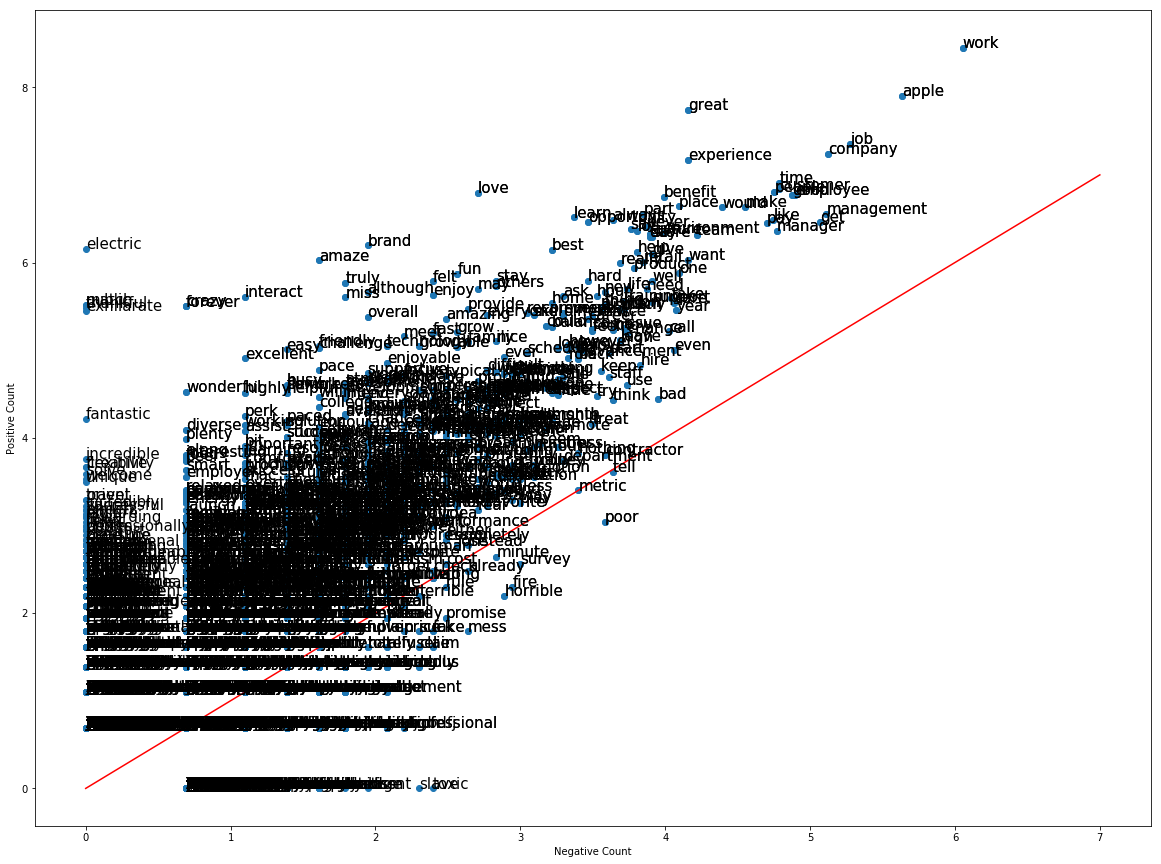

In [460]:
fig, ax = plt.subplots(figsize=(20, 15))

x = np.log([x[1] + 1 for x in data])
y = np.log([x[2] + 1 for x in data])

ax.scatter(x, y)

plt.xlabel('Negative Count')
plt.ylabel('Positive Count')

for i in range(0, len(data)): 
    # the annotate() function draws an arrow connecting two points on the plot 
    #  but this is actually called in ax.plot() [0,9] [0,9] are the two points
    # data[i][0] select the i list in the list 'data' and [0] will select the actual word
    # x[i] and y[i] will select the neg_count and pos_count for the data[i][0] word
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=15)    
ax.plot([0,7], [0,7], color='red')
plt.show()

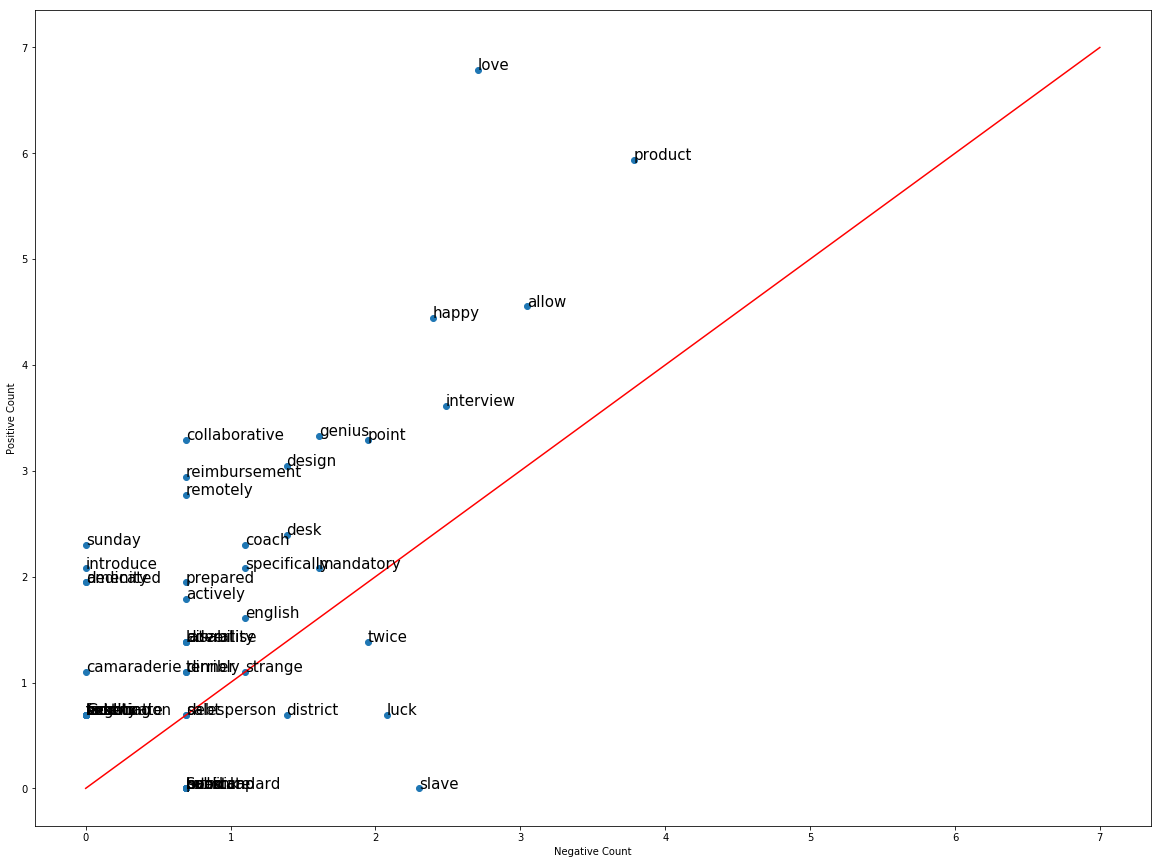

In [485]:
fig, ax = plt.subplots(figsize=(20, 15))
data_rand = random.sample(data, 50)

x = np.log([x[1] + 1 for x in data_rand])
y = np.log([x[2] + 1 for x in data_rand])

ax.scatter(x, y)

plt.xlabel('Negative Count')
plt.ylabel('Positive Count')

for i in range(0, len(data_rand)): 
    ax.annotate(data_rand[i][0], (x[i], y[i]), fontsize=15)    
ax.plot([0,7], [0,7], color='red')
plt.show()

## Feature Engineering
- Given a word, how many times that word shows up in the positive and negative class
- Your vocabulary is the list of all unique words in all reviews
- The first feature will be the sum of all the negative frequencies for every unqiue word in the review. For example, look at our frequencies dictionary for negative review words.  Let's assume we have a review with the following words ['work', 'apple', 'contractor']. Looking at the previously calculated "frequencies" dictionary, the feature 1 value for this review would be 739 or (425+279+35=739).
- The 2nd feature is the sum of all the frequencies for ever unique negative word in the review.  



In [488]:
def features(review, frequencies):
    x = np.zeros((1,2))
    
    for word in review:
        if (word, 0) in frequencies:
            x[0,1] += frequencies.get((word, 0.0),0)
        if (word, 1) in frequencies:
            x[0,0]+= frequencies.get((word, 1.0),0)
    assert(x.shape == (1, 2))
    return x

In [489]:
X = np.zeros((len(df), 2))
for i in range(len(df['length'])):
    X[i, :] = features(df['length'][i], frequencies)
X

array([[ 6790., 54693.],
       [ 3129., 26735.],
       [ 1079.,  9780.],
       ...,
       [ 1279., 14357.],
       [ 1491., 14740.],
       [ 2321., 22483.]])

In [490]:
X_df = pd.DataFrame(X, columns=['neg_count', 'pos_count'])

In [491]:
reviews_df = pd.concat([X_df, df['sentiment']], axis=1)
reviews_df.head()

,neg_count,pos_count,sentiment
0,6790.0,54693.0,1.0
1,3129.0,26735.0,1.0
2,1079.0,9780.0,1.0
3,1139.0,10046.0,1.0
4,2176.0,19450.0,1.0


In [361]:
X = reviews_df.drop('sentiment', axis=1)
y = reviews_df['sentiment']

## Classifier Evaluation

In [422]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews_df.drop('sentiment', axis=1),
    reviews_df['sentiment'], 
    test_size=0.25)

### Stratified k-fold Cross Validation on Training Data with SMOTE at each Fold
- It would seem Gradient Boosting Classifier produced the most balanced model.

In [506]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('knn', KNeighborsClassifier()))
models.append(('bayes', GaussianNB()))
models.append(('svc', SVC()))
models.append(('gbc', GradientBoostingClassifier()))

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
skf = StratifiedKFold(n_splits=10)

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1_score' : 'f1',
            'auc': 'roc_auc'}

for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring, return_train_score=True)    
    for score in list(scores)[2:]:
        print('{} Avg CV {} is {} | std is (+/- {})'.format(name, score, 
            np.mean(scores[score]).round(3), 
            np.std(scores[score]).round(3)))    

log_reg Avg CV test_accuracy is 0.731 | std is (+/- 0.027)
log_reg Avg CV train_accuracy is 0.731 | std is (+/- 0.003)
log_reg Avg CV test_precision is 0.235 | std is (+/- 0.022)
log_reg Avg CV train_precision is 0.235 | std is (+/- 0.003)
log_reg Avg CV test_recall is 0.74 | std is (+/- 0.077)
log_reg Avg CV train_recall is 0.744 | std is (+/- 0.01)
log_reg Avg CV test_f1_score is 0.357 | std is (+/- 0.031)
log_reg Avg CV train_f1_score is 0.358 | std is (+/- 0.004)
log_reg Avg CV test_auc is 0.828 | std is (+/- 0.034)
log_reg Avg CV train_auc is 0.828 | std is (+/- 0.004)
rf_classifer Avg CV test_accuracy is 0.781 | std is (+/- 0.021)
rf_classifer Avg CV train_accuracy is 1.0 | std is (+/- 0.0)
rf_classifer Avg CV test_precision is 0.232 | std is (+/- 0.03)
rf_classifer Avg CV train_precision is 0.999 | std is (+/- 0.001)
rf_classifer Avg CV test_recall is 0.51 | std is (+/- 0.094)
rf_classifer Avg CV train_recall is 1.0 | std is (+/- 0.0)
rf_classifer Avg CV test_f1_score is 0.318 |

" \n        \n    classifier.fit(X_train_rf_smote, y_train_rf_smote)\n    y_preds = classifier.predict(X_test_rf)\n    test_recall = recall_score(y_test, y_preds, average='binary')\n    testing_results.append(test_recall)\n    test_class = classification_report(y_test, y_preds)\n    print('{}: recall w/ RF features on testing data {}:'.format(name, test_recall.round(3)))\n   \n    print(test_class)\n"

In [515]:
sorted(pipeline.get_params().keys())

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_impurity_split',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__presort',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingcla

In [738]:
# BASE MODEL with Default Hyperparameters
clf = GradientBoostingClassifier(random_state=42)
                                       
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

clf.fit(X_train_sm, y_train_sm)
train_auc = cross_val_score(clf, X_train_smote, y_train_smote, cv=10, scoring='roc_auc')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
roc_auc = roc_auc_score(y_test, y_pred).round(3)
print('Training CV AUC:', train_auc)
print('Training Avg CV AUC:', train_auc.mean().round(3))
print('Test Auc:', roc_auc)

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84       890
         1.0       0.25      0.71      0.36       104

    accuracy                           0.74       994
   macro avg       0.60      0.73      0.60       994
weighted avg       0.88      0.74      0.79       994

[[662 228]
 [ 30  74]]
Training CV AUC: [0.7405522  0.73002049 0.75141825 0.78406493 0.80240509 0.79198663
 0.78650777 0.76524482 0.7843447  0.74196027]
Training Avg AUC: 0.768
Test Auc: 0.728


In [ ]:
param_grid = dict(gradientboostingclassifier__learning_rate=learning_rate, 
                  gradientboostingclassifier__n_estimators=n_estimators, 
                  gradientboostingclassifier__min_samples_split = min_samples_split,
                  gradientboostingclassifier__min_samples_leaf = min_samples_leaf,
                  gradientboostingclassifier__max_depth=max_depth)

In [774]:
learning_rate = [0.05,0.01]
n_estimators = range(940,960,1)

param_grid = dict(gradientboostingclassifier__learning_rate=learning_rate,
                 gradientboostingclassifier__n_estimators=n_estimators)

gbc = GradientBoostingClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10)
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
pipeline = make_pipeline(sm, gbc)

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid, 
                    scoring='roc_auc', 
                    verbose=1, 
                    n_jobs=-1, 
                    cv=skf,
                    return_train_score=True
                   )
grid_results = grid.fit(X_train, y_train) 

print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.7min finished


Best Score:  0.7940111940298508
Best Params:  {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 959}


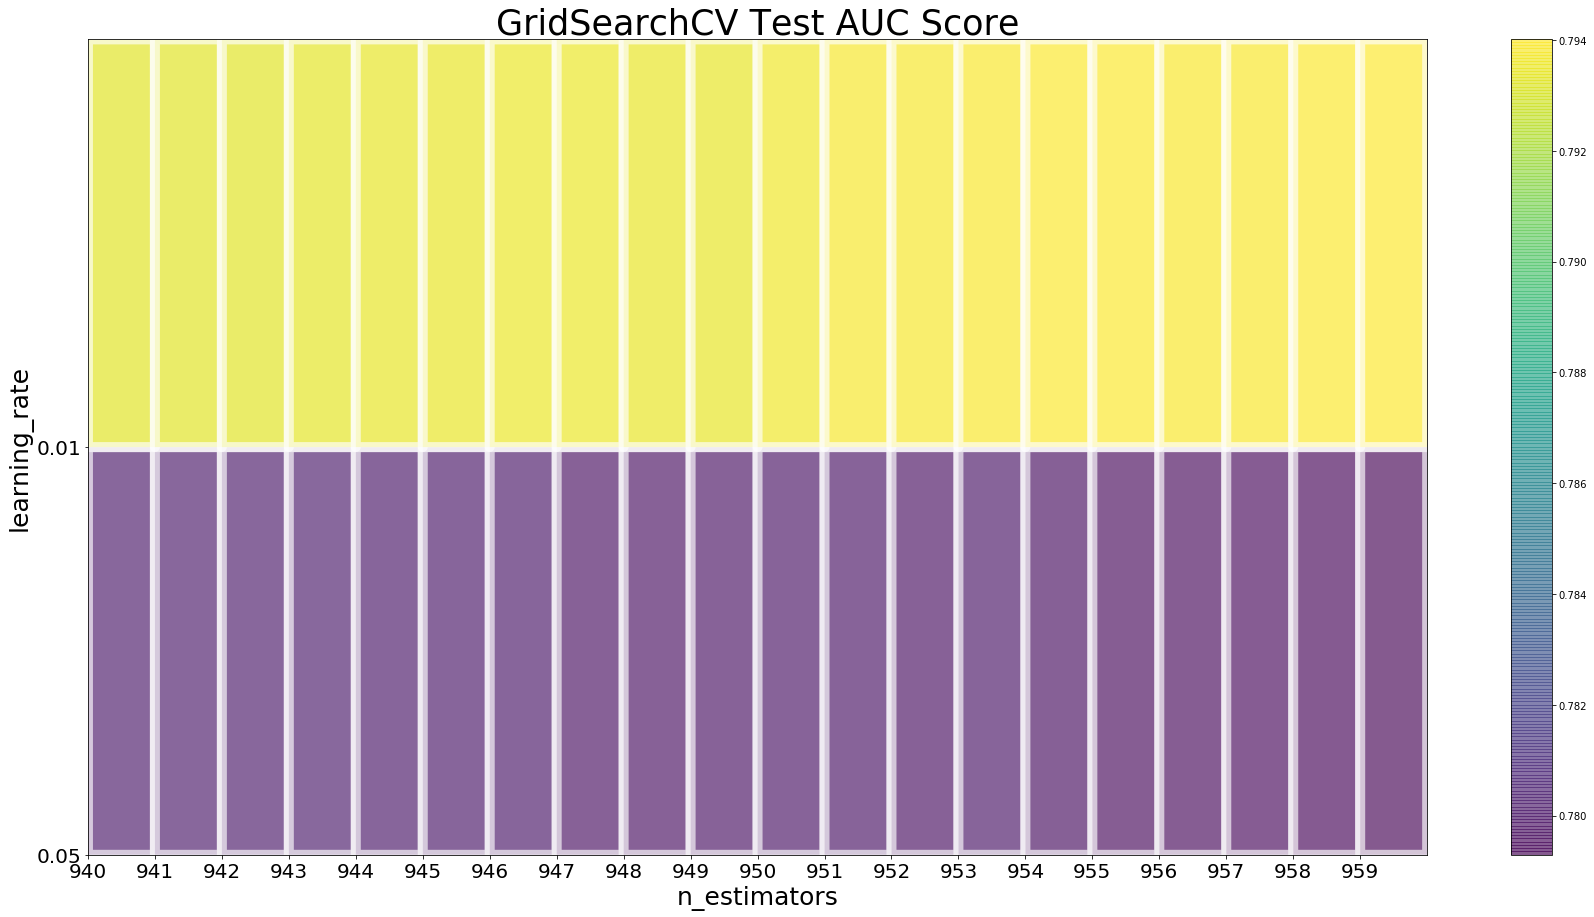

In [823]:
scores = grid_results.cv_results_['mean_test_score'].reshape(len(learning_rate),len(n_estimators))

plt.figure(figsize=(30, 15))
plt.pcolor(scores, cmap='viridis', alpha=0.65, edgecolor='white', linewidths=10)
plt.xlabel('n_estimators', fontsize=25)
plt.ylabel('learning_rate', fontsize=25)
plt.colorbar()
plt.xticks(np.arange(len(n_estimators)), n_estimators, fontsize=20)
plt.yticks(np.arange(len(learning_rate)), learning_rate, fontsize=20)
plt.title('GridSearchCV Test AUC Score', fontsize=35)
plt.show()

In [827]:
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

param_grid = dict(gradientboostingclassifier__max_depth=max_depth)

gbc = GradientBoostingClassifier(random_state=42,
                                 learning_rate = 0.01,
                                 n_estimators = 959)
skf = StratifiedKFold(n_splits=10)
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
pipeline = make_pipeline(sm, gbc)

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='roc_auc', 
                    verbose=1, 
                    n_jobs=-1, 
                    cv=skf,
                    return_train_score=True)
grid_results = grid.fit(X_train, y_train) 

print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  3.7min finished


Best Score:  0.7941417910447761
Best Params:  {'gradientboostingclassifier__max_depth': 2}


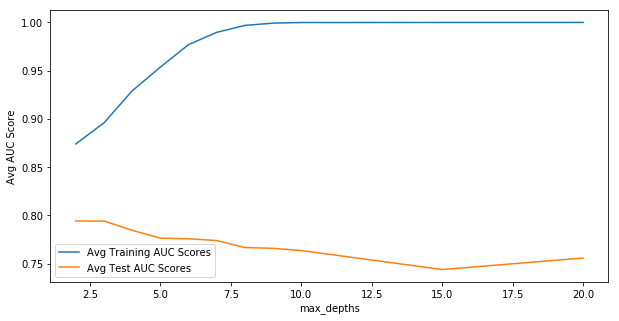

In [825]:
cv_results_df = pd.DataFrame(grid_results.cv_results_)
cv_results_df.rename(columns={'param_gradientboostingclassifier__max_depth': 'max_depth'}, inplace=True)
train_scores_mean = cv_results_df["mean_train_score"]
test_scores_mean = cv_results_df["mean_test_score"]
max_depths = cv_results_df['max_depth']

plt.figure(figsize=(10,5))
plt.plot(max_depths, train_scores_mean, label='Avg Training AUC Scores')
plt.plot(max_depths, test_scores_mean, label='Avg Test AUC Scores')
plt.xlabel('max_depths')
plt.ylabel('Avg AUC Score')
plt.legend()
plt.show()

In [760]:
# FIRST MODEL WITH SOME TUNING
# a little bit of improvement
clf = GradientBoostingClassifier(random_state=42,
                                 learning_rate = 0.01,
                                 n_estimators = 959,
                                 max_depth=2)
                                       
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

clf.fit(X_train_sm, y_train_sm)
train_auc = cross_val_score(clf, X_train_smote, y_train_smote, cv=10, scoring='roc_auc')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
roc_auc = roc_auc_score(y_test, y_pred).round(3)
print('Training CV AUC:', train_auc)
print('Training Avg AUC:', train_auc.mean().round(3))
print('Test Auc:', roc_auc)

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.84       890
         1.0       0.25      0.71      0.37       104

    accuracy                           0.75       994
   macro avg       0.61      0.73      0.61       994
weighted avg       0.88      0.75      0.79       994

[[672 218]
 [ 30  74]]
Training CV AUC: [0.7369931  0.71292601 0.74327006 0.74942299 0.78809858 0.77188309
 0.7582884  0.7442569  0.76422914 0.71908544]
Training Avg AUC: 0.749
Test Auc: 0.733


In [833]:
min_samples_split = [2,3,4,5]

param_grid = dict(gradientboostingclassifier__min_samples_split = min_samples_split)

gbc = GradientBoostingClassifier(random_state=42,
                                 learning_rate=0.01,
                                 n_estimators=959,
                                 max_depth=2)
skf = StratifiedKFold(n_splits=10)
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
pipeline = make_pipeline(sm, gbc)

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='roc_auc', 
                    verbose=1, 
                    n_jobs=-1, 
                    cv=skf,
                    return_train_score=True)
grid_results = grid.fit(X_train, y_train) 

print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.5s finished


Best Score:  0.7904912935323383
Best Params:  {'gradientboostingclassifier__min_samples_split': 0.1}


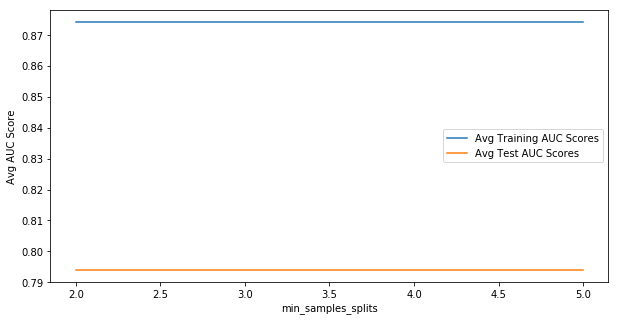

In [831]:
cv_results_df = pd.DataFrame(grid_results.cv_results_)
cv_results_df.rename(columns={'param_gradientboostingclassifier__min_samples_split': 'min_samples_split'}, inplace=True)
train_scores_mean = cv_results_df["mean_train_score"]
test_scores_mean = cv_results_df["mean_test_score"]
min_samples_splits = cv_results_df['min_samples_split']

plt.figure(figsize=(10,5))
plt.plot(min_samples_splits, train_scores_mean, label='Avg Training AUC Scores')
plt.plot(min_samples_splits, test_scores_mean, label='Avg Test AUC Scores')
plt.xlabel('min_samples_splits')
plt.ylabel('Avg AUC Score')
plt.legend()
plt.show()

In [835]:
min_samples_leaf = range(10,30,1)

param_grid = dict(gradientboostingclassifier__min_samples_leaf = min_samples_leaf)

gbc = GradientBoostingClassifier(random_state=42,
                                 learning_rate=0.01,
                                 n_estimators=959,
                                 max_depth=2,
                                 min_samples_split=2
                                )
skf = StratifiedKFold(n_splits=10)
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
pipeline = make_pipeline(sm, gbc)

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='roc_auc', 
                    verbose=1, 
                    n_jobs=-1, 
                    cv=skf,
                    return_train_score=True)
grid_results = grid.fit(X_train, y_train) 

print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


Best Score:  0.7960199004975125
Best Params:  {'gradientboostingclassifier__min_samples_leaf': 26}


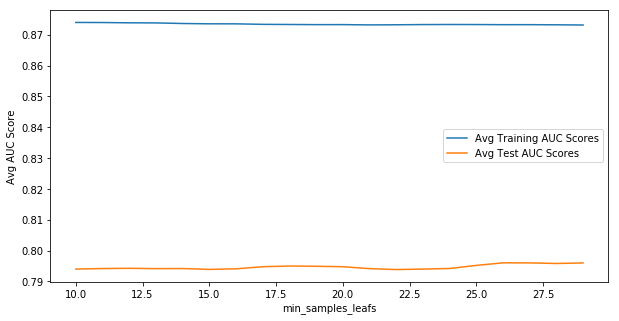

In [836]:
cv_results_df = pd.DataFrame(grid_results.cv_results_)
cv_results_df.rename(columns={'param_gradientboostingclassifier__min_samples_leaf': 'min_samples_leaf'}, inplace=True)
train_scores_mean = cv_results_df["mean_train_score"]
test_scores_mean = cv_results_df["mean_test_score"]
min_samples_leafs = cv_results_df['min_samples_leaf']

plt.figure(figsize=(10,5))
plt.plot(min_samples_leafs, train_scores_mean, label='Avg Training AUC Scores')
plt.plot(min_samples_leafs, test_scores_mean, label='Avg Test AUC Scores')
plt.xlabel('min_samples_leafs')
plt.ylabel('Avg AUC Score')
plt.legend()
plt.show()

In [838]:
# testing new model on test set
model_one = GradientBoostingClassifier(random_state=42,
                                       learning_rate=0.01,
                                       n_estimators=959,
                                       max_depth=2,
                                       min_samples_split=2,
                                       min_samples_leaf=26)

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

model_one.fit(X_train_sm, y_train_sm)
train_auc = cross_val_score(model_one, X_train_smote, y_train_smote, cv=10, scoring='roc_auc')
y_pred = model_one.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred).round(3)

print(classification_report(y_test, y_pred))
print(cnf_matrix)
print('Training CV AUC:', train_auc)
print('Training Avg CV AUC:', train_auc.mean().round(3))
print('Test Auc:', roc_auc)

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.84       890
         1.0       0.25      0.71      0.37       104

    accuracy                           0.75       994
   macro avg       0.61      0.73      0.61       994
weighted avg       0.88      0.75      0.80       994

[[673 217]
 [ 30  74]]
Training CV AUC: [0.73824418 0.72273512 0.74262834 0.74709879 0.78719802 0.7710041
 0.76184211 0.7494176  0.76367729 0.71783566]
Training Avg CV AUC: 0.75
Test Auc: 0.734


# TESTING BELOW - Please Ignore

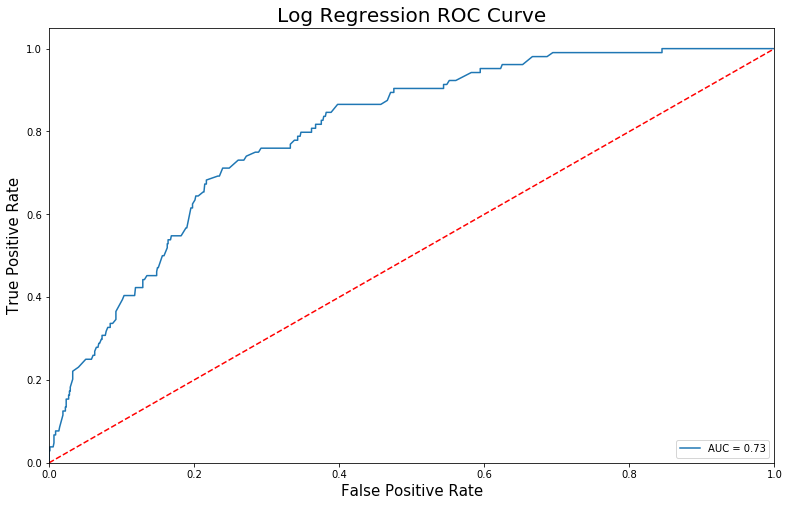

In [772]:
fpr, tpr, thresholds = roc_curve(y_test, model_one.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, y_pred).round(3)
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label= 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('GBC Regression ROC Curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()     


(0, 1)

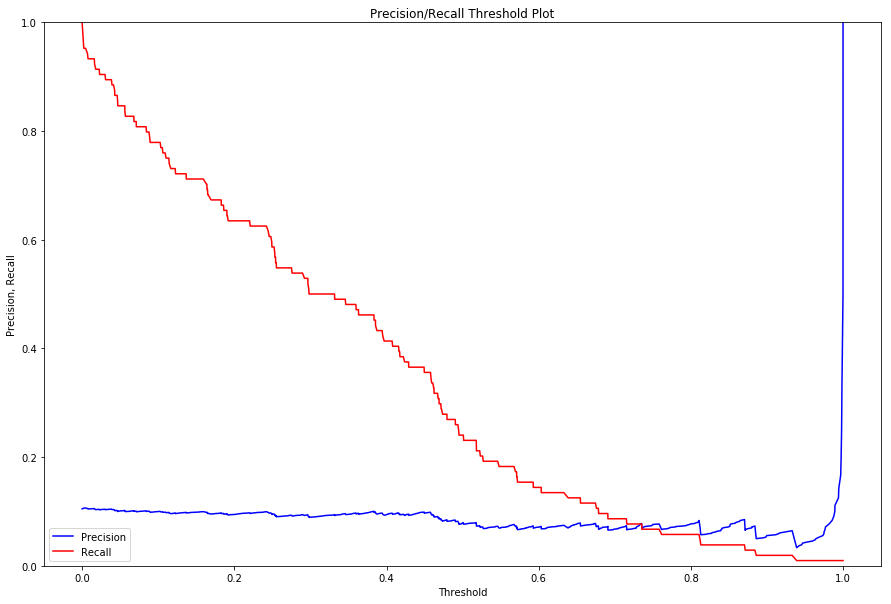

In [773]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1]) 

pr_auc = auc(recall, precision)
plt.figure(figsize=(15,10))
plt.title("Precision/Recall Threshold Plot")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [294]:
model = LogisticRegression()

model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)
THRESHOLD = 0.4 
y_pred_proba_new_threshold = (model.predict_proba(X_test)[:,1] >= THRESHOLD).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_proba_new_threshold).round(2)
test_classification = classification_report(y_test, y_pred_proba_new_threshold)
cnf_matrix = confusion_matrix(y_test, y_pred_proba_new_threshold)
print('Accuracy on testing set: {}'.format(test_accuracy))
print(test_classification)


Accuracy on testing set: 0.76
              precision    recall  f1-score   support

         0.0       0.47      0.51      0.49       257
         1.0       0.86      0.83      0.84       896

    accuracy                           0.76      1153
   macro avg       0.66      0.67      0.67      1153
weighted avg       0.77      0.76      0.76      1153



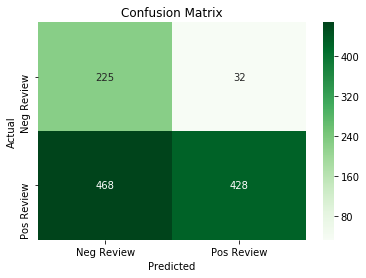

In [293]:
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Greens', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neg Review', 'Pos Review'])
ax.yaxis.set_ticklabels(['Neg Review', 'Pos Review']);